In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('./outputs/rlbench_1cam/rlbench_1cam.pkl', 'rb') as f:
    _obs = pickle.load(f)


IMAGE_SIZE = 128
SCENE_BOUNDS = [1.3, 1.175, 1.45, 1.55, 1.4, 1.7]

keys: dict_keys(['rgb', 'depth', 'position', 'resolution', 'extrinsics', 'intrinsics', 'pointcloud'])
rgb (128, 128, 3)
pcd (128, 128, 3)
resolution [128, 128]


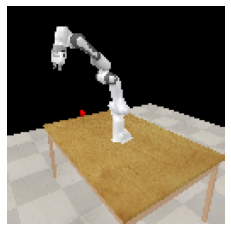

In [3]:
idx = -1
print('keys:',_obs[idx].keys())
print('rgb',_obs[idx]['rgb'].shape)
print('pcd',_obs[idx]['pointcloud'].shape)
print('resolution',_obs[idx]['resolution'])
rgb = _obs[-1]['rgb']
plt.imshow(rgb)
plt.axis('off')

plt.show()

## Visualize

In [4]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"


In [5]:
# reshape pointcloud
pc = _obs[1]['pointcloud'].transpose(2,0,1).reshape(3,-1)

# [x_min, y_min, z_min, x_max, y_max, z_max] - the metric volume to be voxelized
pc = pc[:, ( (pc[0,:] > SCENE_BOUNDS[0]) & (pc[0,:] < SCENE_BOUNDS[3])  )] # x axis constrainsts
pc = pc[:, ( (pc[1,:] > SCENE_BOUNDS[1]) & (pc[1,:] < SCENE_BOUNDS[4])  )] # y axis constrainsts
pc = pc[:, ( (pc[2,:] > SCENE_BOUNDS[2]) & (pc[2,:] < SCENE_BOUNDS[5])  )] # z axis constrainsts

fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        x = pc[0,:],
        y = pc[1,:],
        z = pc[2,:],
        mode='markers',
        marker=dict(
            size=5,
            color=pc[1,:],
            colorscale='Turbo',
        )
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)

# fig.write_html('./observations/rlbench_1cam_pc.html')

fig.show()

In [6]:
rgb.transpose(2,0,1)[0,:]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.73333335, 0.74509805, 0.74509805, ..., 0.7254902 , 0.7294118 ,
        0.72156864],
       [0.7411765 , 0.74509805, 0.74509805, ..., 0.7254902 , 0.72156864,
        0.7137255 ],
       [0.7411765 , 0.7294118 , 0.7294118 , ..., 0.72156864, 0.7176471 ,
        0.7137255 ]], dtype=float32)

In [7]:

"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ARM utilities
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""


from functools import reduce as funtool_reduce
from operator import mul

import torch
from torch import nn, einsum
import torch.nn.functional as F


os.environ["DISPLAY"] = ":0"
os.environ["PYOPENGL_PLATFORM"] = "egl"

MIN_DENOMINATOR = 1e-12
INCLUDE_PER_VOXEL_COORD = True


class VoxelGrid(nn.Module):

    def __init__(
        self,
        coord_bounds,
        voxel_size: int,
        device,
        feature_size,
        max_num_coords: int,
        batch_size:int=1,
    ):
        super(VoxelGrid, self).__init__()
        self._device = device
        self._voxel_size = voxel_size
        self._voxel_shape = [voxel_size] * 3
        self._voxel_d = float(self._voxel_shape[-1])
        self._voxel_feature_size = 4 + feature_size
        self._voxel_shape_spec = torch.tensor(self._voxel_shape,
                                              device=device).unsqueeze(
            0) + 2  # +2 because we crop the edges.
        self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
                                          device=device).unsqueeze(0)
        max_dims = self._voxel_shape_spec[0]
        self._total_dims_list = torch.cat(
            [torch.tensor([batch_size], device=device), max_dims,
             torch.tensor([4 + feature_size], device=device)], -1).tolist()
        self._ones_max_coords = torch.ones((batch_size, max_num_coords, 1),
                                           device=device)
        self._num_coords = max_num_coords

        shape = self._total_dims_list

        self._result_dim_sizes = torch.tensor(
            [funtool_reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [
                1], device=device)
        flat_result_size = funtool_reduce(mul, shape, 1)

        self._initial_val = torch.tensor(0, dtype=torch.float,
                                         device=device)
        self._flat_output = torch.ones(flat_result_size, dtype=torch.float,
                                       device=device) * self._initial_val
        self._arange_to_max_coords = torch.arange(4 + feature_size,
                                                  device=device)
        self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float,
                                       device=device)

        self._const_1 = torch.tensor(1.0, device=device)
        self._batch_size = batch_size

        # Coordinate Bounds:
        self._bb_mins = self._coord_bounds[..., 0:3]
        bb_maxs = self._coord_bounds[..., 3:6]
        bb_ranges = bb_maxs - self._bb_mins
        # get voxel dimensions. 'DIMS' mode
        self._dims = dims = self._voxel_shape_spec.int()
        self._dims_orig = dims_orig = self._voxel_shape_spec.int() - 2
        self._dims_m_one = (dims - 1).int()
        # BS x 1 x 3
        self._res = bb_ranges / (dims_orig.float() + MIN_DENOMINATOR)
        self._res_minis_2 = bb_ranges / (dims.float() - 2 + MIN_DENOMINATOR)

        self._voxel_indicy_denmominator = self._res + MIN_DENOMINATOR
        self._dims_m_one_zeros = torch.zeros_like(self._dims_m_one)

        batch_indices = torch.arange(self._batch_size, dtype=torch.int,
                                     device=device).view(self._batch_size, 1, 1)
        self._tiled_batch_indices = batch_indices.repeat(
            [1, self._num_coords, 1])

        w = self._voxel_shape[0] + 2
        arange = torch.arange(0, w, dtype=torch.float, device=device)
        self._index_grid = torch.cat([
            arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
            arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
            arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
            0).repeat([self._batch_size, 1, 1, 1, 1])

    def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
        if dim < 0:
            dim = other.dim() + dim
        if src.dim() == 1:
            for _ in range(0, dim):
                src = src.unsqueeze(0)
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def _scatter_mean(
        self, 
        src: torch.Tensor, 
        index: torch.Tensor, 
        out: torch.Tensor,
        dim: int = -1
    ):
        print(f'out: {out.shape} src: {src.shape}')
        print(f'out: {out.dtype} src: {src.dtype}')
        
        out = out.scatter_add_(dim, index, src)

        index_dim = dim
        if index_dim < 0:
            index_dim = index_dim + src.dim()
        if index.dim() <= index_dim:
            index_dim = index.dim() - 1

        ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
        out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
        out_count = out_count.scatter_add_(index_dim, index, ones)
        out_count.clamp_(1)
        count = self._broadcast(out_count, out, dim)
        if torch.is_floating_point(out):
            out.true_divide_(count)
        else:
            out.floor_divide_(count)
        return out

    def _scatter_nd(self, indices, updates):
        indices_shape = indices.shape
        num_index_dims = indices_shape[-1]
        flat_updates = updates.view((-1,))
        indices_scales = self._result_dim_sizes[0:num_index_dims].view(
            [1] * (len(indices_shape) - 1) + [num_index_dims])
        indices_for_flat_tiled = ((indices * indices_scales).sum(
            dim=-1, keepdims=True)).view(-1, 1).repeat(
            *[1, self._voxel_feature_size])

        implicit_indices = self._arange_to_max_coords[
                           :self._voxel_feature_size].unsqueeze(0).repeat(
            *[indices_for_flat_tiled.shape[0], 1])
        indices_for_flat = indices_for_flat_tiled + implicit_indices
        flat_indices_for_flat = indices_for_flat.view((-1,)).long()

        flat_scatter = self._scatter_mean(
            flat_updates, flat_indices_for_flat,
            out=torch.zeros_like(self._flat_output))
        return flat_scatter.view(self._total_dims_list)

    def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
                                      coord_bounds=None):
        voxel_indicy_denmominator = self._voxel_indicy_denmominator
        res, bb_mins = self._res, self._bb_mins
        if coord_bounds is not None:
            bb_mins = coord_bounds[..., 0:3]
            bb_maxs = coord_bounds[..., 3:6]
            bb_ranges = bb_maxs - bb_mins
            res = bb_ranges / (self._dims_orig.float() + MIN_DENOMINATOR)
            voxel_indicy_denmominator = res + MIN_DENOMINATOR

        bb_mins_shifted = bb_mins - res  # shift back by one
        floor = torch.floor(
            (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
        voxel_indices = torch.min(floor, self._dims_m_one)
        voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros)

        # global-coordinate point cloud (x, y, z)
        voxel_values = coords

        # rgb values (R, G, B)
        if coord_features is not None:
            voxel_values = torch.cat([voxel_values, coord_features], -1) # concat rgb values (B, 128, 128, 3)

        # coordinates to aggregate over
        _, num_coords, _ = voxel_indices.shape
        all_indices = torch.cat([
            self._tiled_batch_indices[:, :num_coords], voxel_indices], -1)

        # max coordinates
        voxel_values_pruned_flat = torch.cat(
            [voxel_values, self._ones_max_coords[:, :num_coords]], -1)

        # aggregate across camera views
        scattered = self._scatter_nd(
            all_indices.view([-1, 1 + 3]),
            voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

        vox = scattered[:, 1:-1, 1:-1, 1:-1]
        if INCLUDE_PER_VOXEL_COORD:
            res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
            coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
                1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
            vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

        # occupied value
        occupied = (vox[..., -1:] > 0).float()
        vox = torch.cat([
            vox[..., :-1], occupied], -1)

        # hard voxel-location position encoding
        return torch.cat(
           [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2] / self._voxel_d,
            vox[..., -1:]], -1)



from scipy.spatial.transform import Rotation
import pyrender
import trimesh
from pyrender.trackball import Trackball

def stack_on_channel(x):
    # expect (B, T, C, ...)
    return torch.cat(torch.split(x, 1, dim=1), dim=2).squeeze(1)


def _compute_initial_camera_pose(scene):
    # Adapted from:
    # https://github.com/mmatl/pyrender/blob/master/pyrender/viewer.py#L1032
    centroid = scene.centroid
    scale = scene.scale
    # if scale == 0.0:
    #     scale = DEFAULT_SCENE_SCALE
    scale = 4.0
    s2 = 1.0 / np.sqrt(2.0)
    cp = np.eye(4)
    cp[:3, :3] = np.array([[0.0, -s2, s2], [1.0, 0.0, 0.0], [0.0, s2, s2]])
    hfov = np.pi / 6.0
    dist = scale / (2.0 * np.tan(hfov))
    cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
    return cp


def _from_trimesh_scene(
        trimesh_scene, bg_color=None, ambient_light=None):
    # convert trimesh geometries to pyrender geometries
    geometries = {name: pyrender.Mesh.from_trimesh(geom, smooth=False)
                  for name, geom in trimesh_scene.geometry.items()}
    # create the pyrender scene object
    scene_pr = pyrender.Scene(bg_color=bg_color, ambient_light=ambient_light)
    # add every node with geometry to the pyrender scene
    for node in trimesh_scene.graph.nodes_geometry:
        pose, geom_name = trimesh_scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)
    return scene_pr


def create_voxel_scene(
        voxel_grid: np.ndarray,
        voxel_size: float = 0.1,
        alpha: float = 0.5):
    # _, d, h, w = voxel_grid.shape
    v = voxel_grid.transpose((1, 2, 3, 0))
    occupancy = v[:, :, :, -1] != 0
    alpha = np.expand_dims(np.full_like(occupancy, alpha, dtype=np.float32), -1)
    rgb = np.concatenate([(v[:, :, :, 3:6] + 1)/ 2.0, alpha], axis=-1)

    transform = trimesh.transformations.scale_and_translate(
        scale=voxel_size, translate=(0.0, 0.0, 0.0))
    trimesh_voxel_grid = trimesh.voxel.VoxelGrid(
        encoding=occupancy, transform=transform)
    geometry = trimesh_voxel_grid.as_boxes(colors=rgb)
    scene = trimesh.Scene()
    scene.add_geometry(geometry)
    return scene


def visualise_voxel(
    voxel_grid: np.ndarray,
    rotation_amount: float = 0.0,
    show: bool = False,
    voxel_size: float = 0.1,
    offscreen_renderer: pyrender.OffscreenRenderer = None,
    alpha: float = 0.5,
):
    scene = create_voxel_scene(
        voxel_grid, 
        voxel_size,
        alpha
    )
    if show:
        scene.show()
    else:
        r = offscreen_renderer or pyrender.OffscreenRenderer(
            viewport_width=1920, viewport_height=1080, point_size=1.0)
        s = _from_trimesh_scene(
            scene, ambient_light=[0.8, 0.8, 0.8],
            bg_color=[1.0, 1.0, 1.0])
        cam = pyrender.PerspectiveCamera(
            yfov=np.pi / 4.0, aspectRatio=r.viewport_width/r.viewport_height)
        p = _compute_initial_camera_pose(s)
        t = Trackball(p, (r.viewport_width, r.viewport_height), s.scale, s.centroid)
        t.rotate(rotation_amount, np.array([0.0, 0.0, 1.0]))
        
        # print(t.pose)
        s.add(cam, pose=t.pose)

        color, depth = r.render(s)
        return color.copy()

# from main tutorial 
def _norm_rgb(x):
    # return (x.float() / 255.0) * 2.0 - 1.0  # (0.0, 255.0) -> (-1.0, +1.0)

    return x.float()*2.0 - 1.0 # (0.0, 1.0) -> (-1.0, +1.0)


In [8]:
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
VOXELIZE AND SHOW VOXEL GRID
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""

device = "cuda" if torch.cuda.is_available() else "cpu"

VOXEL_SIZES = [100] # 100x100x100 voxels
BATCH_SIZE = 1
CAMERAS = ['front']

vox_grid = VoxelGrid(
    coord_bounds=SCENE_BOUNDS,
    voxel_size=VOXEL_SIZES[0],
    device=device,
    batch_size=BATCH_SIZE,
    feature_size=3,
    max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
)

In [9]:

obs_dict = dict(
    rgb=_obs[idx]['rgb'].transpose(2,0,1).astype(np.float32),
    pcd=_obs[idx]['pointcloud'].transpose(2,0,1).astype(np.float32),
)

batch = {k: torch.tensor(v).unsqueeze(0).unsqueeze(0) for k,v in obs_dict.items()}
batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}


def _preprocess_inputs(
    sample:dict,
) -> tuple:
    obs, pcds = [], []
    
    # for every camera in the observation
    rgb = stack_on_channel(sample['rgb'])
    pcd = stack_on_channel(sample['pcd'])
    rgb = _norm_rgb(rgb)
    obs.append([rgb, pcd])
    pcds.append(pcd)
    return obs, pcds

obs, pcds = _preprocess_inputs(batch)
bs = obs[0][0].shape[0]


pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)


image_features = [o[0] for o in obs]
feat_size = image_features[0].shape[1]
flat_imag_features = torch.cat(
    [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)



bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# voxelize!
voxel_grid = vox_grid.coords_to_bounding_voxel_grid(
    pcd_flat,
    coord_features=flat_imag_features,
    coord_bounds=bounds
)

# swap to channels fist
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()


out: torch.Size([7428456]) src: torch.Size([114688])
out: torch.float32 src: torch.float32


(-0.5, 1919.5, 1079.5, -0.5)

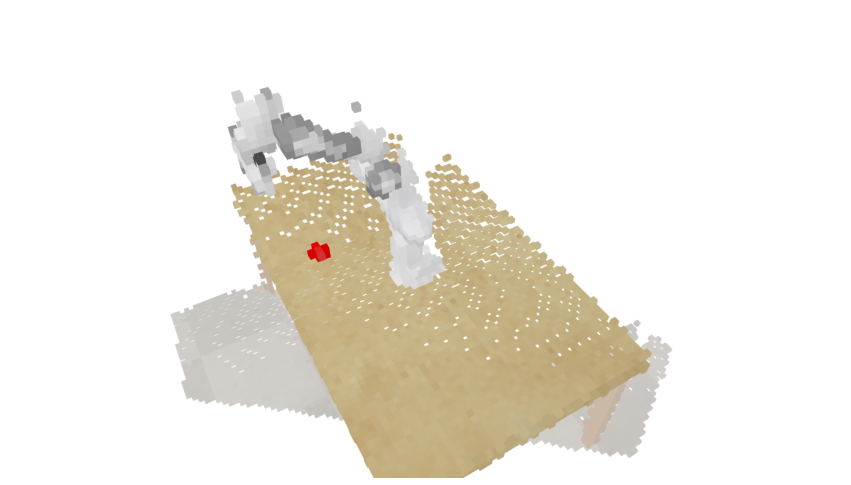

In [10]:
# render voxel grid with expert action (blue)
#@markdown #### Show voxel grid and expert action (blue)
#@markdown Adjust `rotation_amount` to change the camera yaw angle for rendering.
rotation_amount = 60 #@param {type:"slider", min:-180, max:180, step:5}
rendered_img = visualise_voxel(    
    vis_voxel_grid[0],
    voxel_size=0.050,
    rotation_amount=np.deg2rad(rotation_amount),
    alpha=1.0,
    show=False)

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')


In [11]:

voxels = vis_voxel_grid[0]
for param in range(13):
    
    print(param, voxels[param,:,0,0])

0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

In [14]:
for param in range(13):
    print(param, voxels[param,:,50,50])

0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

In [13]:
voxels.shape

(13, 100, 100, 100)